In [1]:
using MLJ 
using CSV, DataFrames
using Plots

Sample standardization procedure

In [2]:
x = rand(100); 
@show mean(x) std(x);

mean(x) = 0.5225230737956157
std(x) = 0.2756380585374146


In [4]:
model = Standardizer()
mach = machine(model, x) 

fit!(mach) 

x̂ = MLJ.transform(mach, x); 

@show mean(x̂) std(x̂); 

mean(x̂) = 2.0650148258027913e-16
std(x̂) = 1.0


┌ Info: Training Machine{Standardizer,…}.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:403


some transformers have an `inverse_transform()` method that we can use to retransform predictions to original distribution. 

In [5]:
inverse_transform(mach, x̂) ≈ x

true

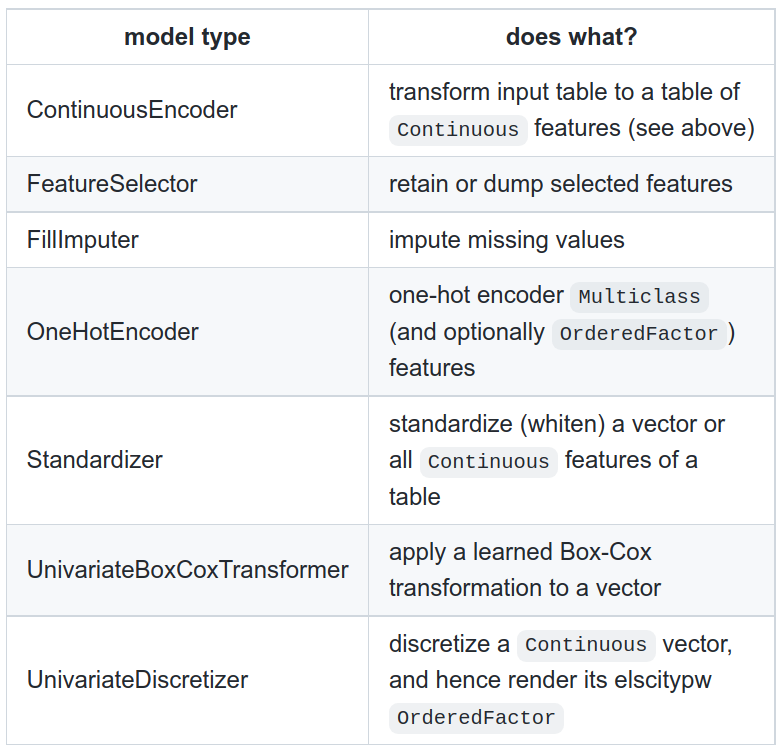

# Pipelines

In [7]:
file = CSV.File(joinpath("data", "house.csv"));
house = DataFrames.DataFrame(file);
coerce!(house, autotype(file));
coerce!(house, Count => Continuous, :zipcode => Multiclass);
schema(house)

┌───────────────┬───────────────────────────────────┬───────────────────┐
│ _.names       │ _.types                           │ _.scitypes        │
├───────────────┼───────────────────────────────────┼───────────────────┤
│ price         │ Float64                           │ Continuous        │
│ bedrooms      │ CategoricalValue{Int64, UInt32}   │ OrderedFactor{13} │
│ bathrooms     │ CategoricalValue{Float64, UInt32} │ OrderedFactor{30} │
│ sqft_living   │ Float64                           │ Continuous        │
│ sqft_lot      │ Float64                           │ Continuous        │
│ floors        │ CategoricalValue{Float64, UInt32} │ OrderedFactor{6}  │
│ waterfront    │ CategoricalValue{Int64, UInt32}   │ OrderedFactor{2}  │
│ view          │ CategoricalValue{Int64, UInt32}   │ OrderedFactor{5}  │
│ condition     │ CategoricalValue{Int64, UInt32}   │ OrderedFactor{5}  │
│ grade         │ CategoricalValue{Int64, UInt32}   │ OrderedFactor{12} │
│ sqft_above    │ Float64             

In [8]:
y, X = unpack(house, ==(:price), name -> true, rng=123);
nothing #hide

In [13]:
using Pkg
Pkg.add("MultivariateStats")
Pkg.add("MLJMultivariateStatsInterface")

   Resolving package versions...
  No Changes to `~/gitRepos/ml-demos/Project.toml`
  No Changes to `~/gitRepos/ml-demos/Manifest.toml`
   Resolving package versions...
    Updating `~/gitRepos/ml-demos/Project.toml`
  [1b6a4a23] + MLJMultivariateStatsInterface v0.2.2
    Updating `~/gitRepos/ml-demos/Manifest.toml`
  [1b6a4a23] + MLJMultivariateStatsInterface v0.2.2


In [14]:
PCA = @load PCA

import MLJMultivariateStatsInterface ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/john/.julia/packages/MLJModels/GKDnU/src/loading.jl:168


MLJMultivariateStatsInterface.PCA

In [16]:
encoder = ContinuousEncoder() 
reducer = PCA()

PCA(
    maxoutdim = 0,
    method = :auto,
    pratio = 0.99,
    mean = nothing)

Let us combine and encoder with our reducer into a single pipeline

In [17]:
pipe = @pipeline encoder reducer

Pipeline276(
    continuous_encoder = ContinuousEncoder(
            drop_last = false,
            one_hot_ordered_factors = false),
    pca = PCA(
            maxoutdim = 0,
            method = :auto,
            pratio = 0.99,
            mean = nothing))

In [18]:
mach = machine(pipe, X)
fit!(mach)

┌ Info: Training Machine{Pipeline276,…}.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:403
┌ Info: Training Machine{ContinuousEncoder,…}.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:403
┌ Info: Training Machine{PCA,…}.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:403


Machine{Pipeline276,…} trained 1 time; caches data
  args: 
    1:	Source @050 ⏎ `Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{70}}, AbstractVector{OrderedFactor{13}}, AbstractVector{OrderedFactor{30}}, AbstractVector{OrderedFactor{6}}, AbstractVector{OrderedFactor{5}}, AbstractVector{OrderedFactor{12}}, AbstractVector{OrderedFactor{2}}}}`


In [21]:
Xsmall = MLJ.transform(mach, X)

,x1,x2
,Float64,Float64
1,13780.9,2064.66
2,-25865.5,-11110.0
3,14538.9,2296.6
4,-31003.0,-10265.1
5,15358.4,2523.98
6,12630.7,1771.82
7,8949.6,755.842
8,-5036.35,1742.77
9,-7034.88,-4323.38


In [22]:
schema(Xsmall)

┌─────────┬─────────┬────────────┐
│ _.names │ _.types │ _.scitypes │
├─────────┼─────────┼────────────┤
│ x1      │ Float64 │ Continuous │
│ x2      │ Float64 │ Continuous │
└─────────┴─────────┴────────────┘
_.nrows = 21613


In [23]:
Pkg.add("MLJLinearModels")

   Resolving package versions...
    Updating `~/gitRepos/ml-demos/Project.toml`
  [6ee0df7b] + MLJLinearModels v0.5.7
    Updating `~/gitRepos/ml-demos/Manifest.toml`
  [6a86dc24] + FiniteDiff v2.8.1
  [42fd0dbc] + IterativeSolvers v0.9.2
  [d3d80556] + LineSearches v7.1.1
  [7a12625a] + LinearMaps v3.5.1
  [6ee0df7b] + MLJLinearModels v0.5.7
  [d41bc354] + NLSolversBase v7.8.2
  [429524aa] + Optim v1.5.0
  [85a6dd25] + PositiveFactorizations v0.2.4


We can even combine the preprocessing step with our model into one trainable pipeline

In [24]:
RidgeRegressor = @load RidgeRegressor pkg=MLJLinearModels
rgs = RidgeRegressor()
pipe2 = @pipeline encoder reducer rgs

import MLJLinearModels ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/john/.julia/packages/MLJModels/GKDnU/src/loading.jl:168
┌ Info: Precompiling MLJLinearModels [6ee0df7b-362f-4a72-a706-9e79364fb692]
└ @ Base loading.jl:1423


Pipeline284(
    continuous_encoder = ContinuousEncoder(
            drop_last = false,
            one_hot_ordered_factors = false),
    pca = PCA(
            maxoutdim = 0,
            method = :auto,
            pratio = 0.99,
            mean = nothing),
    ridge_regressor = RidgeRegressor(
            lambda = 1.0,
            fit_intercept = true,
            penalize_intercept = false,
            solver = nothing))

In [25]:
mach = machine(pipe2, X, y)
evaluate!(mach, measure=mae, resampling=Holdout()) # CV(nfolds=6) is default

PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌─────────────────────┬─────────────┬───────────┬────────────┐
│ measure             │ measurement │ operation │ per_fold   │
├─────────────────────┼─────────────┼───────────┼────────────┤
│ MeanAbsoluteError() │ 234000.0    │ predict   │ [234000.0] │
└─────────────────────┴─────────────┴───────────┴────────────┘


It's still possible to do warm restarts!

In [26]:
fit!(mach)

┌ Info: Training Machine{Pipeline284,…}.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:403
┌ Info: Training Machine{ContinuousEncoder,…}.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:403
┌ Info: Training Machine{PCA,…}.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:403
┌ Info: Training Machine{RidgeRegressor,…}.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:403


Machine{Pipeline284,…} trained 2 times; caches data
  args: 
    1:	Source @215 ⏎ `Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{70}}, AbstractVector{OrderedFactor{13}}, AbstractVector{OrderedFactor{30}}, AbstractVector{OrderedFactor{6}}, AbstractVector{OrderedFactor{5}}, AbstractVector{OrderedFactor{12}}, AbstractVector{OrderedFactor{2}}}}`
    2:	Source @528 ⏎ `AbstractVector{Continuous}`


In [27]:
pipe2.ridge_regressor.lambda = 0.1
fit!(mach)

┌ Info: Updating Machine{Pipeline284,…}.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:404
┌ Info: Not retraining Machine{ContinuousEncoder,…}. Use `force=true` to force.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:406
┌ Info: Not retraining Machine{PCA,…}. Use `force=true` to force.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:406
┌ Info: Updating Machine{RidgeRegressor,…}.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:404


Machine{Pipeline284,…} trained 3 times; caches data
  args: 
    1:	Source @215 ⏎ `Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{70}}, AbstractVector{OrderedFactor{13}}, AbstractVector{OrderedFactor{30}}, AbstractVector{OrderedFactor{6}}, AbstractVector{OrderedFactor{5}}, AbstractVector{OrderedFactor{12}}, AbstractVector{OrderedFactor{2}}}}`
    2:	Source @528 ⏎ `AbstractVector{Continuous}`


In [28]:
pipe2.pca.pratio = 0.9999
fit!(mach)

┌ Info: Updating Machine{Pipeline284,…}.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:404
┌ Info: Not retraining Machine{ContinuousEncoder,…}. Use `force=true` to force.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:406
┌ Info: Updating Machine{PCA,…}.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:404
┌ Info: Training Machine{RidgeRegressor,…}.
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/machines.jl:403


Machine{Pipeline284,…} trained 4 times; caches data
  args: 
    1:	Source @215 ⏎ `Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{70}}, AbstractVector{OrderedFactor{13}}, AbstractVector{OrderedFactor{30}}, AbstractVector{OrderedFactor{6}}, AbstractVector{OrderedFactor{5}}, AbstractVector{OrderedFactor{12}}, AbstractVector{OrderedFactor{2}}}}`
    2:	Source @528 ⏎ `AbstractVector{Continuous}`


# Inspecting composite models

In [29]:
fitted_params(mach).ridge_regressor

(coefs = [:x1 => -0.7328956348956993, :x2 => -0.1659056320291543, :x3 => 194.59515890822144, :x4 => 102.71301756136124],
 intercept = 540085.6428739978,)

In [30]:
report(mach).pca

(indim = 87,
 outdim = 4,
 tprincipalvar = 2.463215246230866e9,
 tresidualvar = 157533.26199674606,
 tvar = 2.4633727794928627e9,
 mean = [4.369869985656781, 8.45912182482765, 2079.8997362698374, 15106.967565816869, 1.988617961412113, 1.0075417572757137, 1.2343034284921113, 3.4094295100171195, 6.6569194466293435, 1788.3906907879516  …  0.011798454633785222, 0.012122333780595013, 0.006292509138018785, 0.012955165872391617, 0.01466709850552908, 47.560052519317075, -122.21389640494147, 1986.552491556008, 12768.455651691113, 1.9577106371165502],
 principalvars = [2.177071551045086e9, 2.841813972643023e8, 1.6850160830643442e6, 277281.8384132337],)

# Target Transformations

Suppose we want the model to train on the log of `:price` but report actual price values for validation/predictions

In [31]:
# overload log and exp for array use 
Base.log(X::AbstractArray) = log.(X)
Base.exp(X::AbstractArray) = exp.(X)

In [32]:
pipe3 = @pipeline encoder reducer rgs target=log inverse=exp

┌ Info: Treating pipeline as a `Deterministic` predictor.
│ To override, specify `prediction_type=...` (options: :deterministic, :probabilistic, :interval). 
└ @ MLJBase /home/john/.julia/packages/MLJBase/QXObv/src/composition/models/pipelines.jl:372


Pipeline297(
    continuous_encoder = ContinuousEncoder(
            drop_last = false,
            one_hot_ordered_factors = false),
    pca = PCA(
            maxoutdim = 0,
            method = :auto,
            pratio = 0.9999,
            mean = nothing),
    ridge_regressor = RidgeRegressor(
            lambda = 0.1,
            fit_intercept = true,
            penalize_intercept = false,
            solver = nothing),
    target = WrappedFunction(
            f = log),
    inverse = WrappedFunction(
            f = exp))

In [33]:
mach = machine(pipe3, X, y)

Machine{Pipeline297,…} trained 0 times; caches data
  args: 
    1:	Source @226 ⏎ `Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{70}}, AbstractVector{OrderedFactor{13}}, AbstractVector{OrderedFactor{30}}, AbstractVector{OrderedFactor{6}}, AbstractVector{OrderedFactor{5}}, AbstractVector{OrderedFactor{12}}, AbstractVector{OrderedFactor{2}}}}`
    2:	Source @664 ⏎ `AbstractVector{Continuous}`


In [34]:
evaluate!(mach, measure=mae)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:06


PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌─────────────────────┬─────────────┬───────────┬───────────────────────────────
│ measure             │ measurement │ operation │ per_fold                     ⋯
├─────────────────────┼─────────────┼───────────┼───────────────────────────────
│ MeanAbsoluteError() │ 162000.0    │ predict   │ [160000.0, 161000.0, 164000. ⋯
└─────────────────────┴─────────────┴───────────┴───────────────────────────────
                                                                1 column omitted
